In [1]:
import os
from pathlib import Path
from PIL import Image
import time

from miniai.imports import *
from miniai.datasets import *
from miniai.diffusion import *

from diffusers import AutoencoderKL
from transformers import CLIPProcessor, CLIPModel

### Get Tiny ImageNet Data

In [ ]:
# Get tiny imagenet from HF
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [ ]:
class TinyHFDS:
    # This is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # The 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # Once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds['image']
    def __len__(self): 
        return self.ds.num_rows
    def __getitem__(self, i): 
        return (torch.ones([3,1,1])*TF.to_tensor(self.image[i]))

In [ ]:
tds = TinyHFDS(dsd['train'])
vds = TinyHFDS(dsd['valid'])

In [ ]:
tdl = DataLoader(tds, batch_size=16, num_workers=8)
vdl = DataLoader(vds, batch_size=16, num_workers=8)

### Save Images as a Single Memory Mapped Numpy Array

In [2]:
def memmap_tensor(dl, mmpath, mmshape, func=lambda x: x):
    # Process dataloader into memmap np.array
    if not mmpath.exists():
        a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
        i = 0
        total = mmshape[0]

        # Batchwise saving
        for xb in dl:
            start_time = time.time()
            n = len(xb)
            a[i:i+n] = to_cpu(func(xb)).numpy()
            i += n
            elapsed_time = time.time() - start_time
            print(f"Saved {i}/{total} in {elapsed_time}");
            
        a.flush()
        del(a)

In [3]:
def tensorify(np_array):
    return torch.tensor(np_array)

In [4]:
# Make directories
path_data = Path("tiny_imgnet")
path_t = path_data/"train"
path_v = path_data/"valid"
os.makedirs(path_t, exist_ok=True)
path_v.mkdir(exist_ok=True)

In [5]:
mmshape_t_img = (100_000, 3, 64, 64)
path_t_img = path_t/"tensor_imgs.npmm"

In [6]:
if not path_t_img.exists():
    memmap_tensor(tdl, path_t_img, mmshape_t_img)
# TODO: Did the 1 channel images get saved properly?

- We need to check if the numpy arrays were actually saved to memory

In [7]:
np_imgs_t = np.memmap(path_t_img, dtype=np.float32, mode='r', shape=mmshape_t_img)

In [8]:
a = tensorify(np_imgs_t[:32])
a[0].mean(), a[-1].mean()

(tensor(0.5259), tensor(0.1365))

In [9]:
b = tensorify(np_imgs_t[-32:])
b[0].mean(), b[-1].mean()

(tensor(0.2521), tensor(0.4186))

- Since the mean of the data isn't 0, the images have all been writen into the file

In [10]:
mmshape_v_img = (10_000, 3, 64, 64)
path_v_img = path_v/"tensor_imgs.npmm"

In [11]:
if not path_v_img.exists():
    memmap_tensor(vdl, path_v_img, mmshape_v_img)

In [12]:
np_imgs_v = np.memmap(path_v_img, dtype=np.float32, mode='r', shape=mmshape_v_img)

In [13]:
a = tensorify(np_imgs_v[:32])
a[0].mean(), a[-1].mean()

(tensor(0.3669), tensor(0.4263))

In [14]:
b = tensorify(np_imgs_v[-32:])
b[0].mean(), b[-1].mean()

(tensor(0.3129), tensor(0.5192))

### Save CLIP Image Embs as a Memory Mapped Numpy Array

In [15]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda").requires_grad_(False)

# Get image embeddings
def clipify(images):
    inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False)
    image_input = inputs["pixel_values"].to("cuda")
    image_features = model.get_image_features(image_input)
    return image_features

In [16]:
c = clipify(a[0])
c.shape

torch.Size([1, 768])

- Read in training tensors via MemmapTensor()
- Clipify training tensors and save

In [17]:
mmshape_t_emb = (100_000, 768)
path_t_emb = path_t/"tensor_embs.npmm"
np_imgs_t = np.memmap(path_t_img, dtype=np.float32, mode='r', shape=mmshape_t_img)

In [18]:
class MemmapTensor:
    def __init__(self, img):
        self.img = img

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, i):
        return torch.tensor(self.img[i])

In [19]:
tds = MemmapTensor(np_imgs_t)

In [20]:
tdl = DataLoader(tds, batch_size=256, num_workers=8)

In [21]:
if not path_t_emb.exists():
    memmap_tensor(tdl, path_t_emb, mmshape_t_emb, func=clipify)

- Repeat for validation set

In [22]:
mmshape_v_emb = (10_000, 768)
path_v_emb = path_v/"tensor_embs.npmm"
np_imgs_v = np.memmap(path_v_img, dtype=np.float32, mode='r', shape=mmshape_v_img)

In [23]:
vds = MemmapTensor(np_imgs_v)

In [24]:
vdl = DataLoader(vds, batch_size=250, num_workers=8)

In [25]:
if not path_v_emb.exists():
    memmap_tensor(vdl, path_v_emb, mmshape_v_emb, func=clipify)

Saved 250/10000 in 71.54294872283936
Saved 500/10000 in 71.39379978179932
Saved 750/10000 in 71.40023446083069
Saved 1000/10000 in 71.55227589607239
Saved 1250/10000 in 73.05780863761902
Saved 1500/10000 in 72.0996925830841
Saved 1750/10000 in 70.92323899269104
Saved 2000/10000 in 71.55779433250427
Saved 2250/10000 in 72.2634928226471
Saved 2500/10000 in 71.89228940010071
Saved 2750/10000 in 71.92849922180176
Saved 3000/10000 in 71.54310059547424
Saved 3250/10000 in 71.28158688545227
Saved 3500/10000 in 72.07819843292236
Saved 3750/10000 in 71.52360534667969
Saved 4000/10000 in 72.67764520645142
Saved 4250/10000 in 72.59994125366211
Saved 4500/10000 in 72.54551982879639
Saved 4750/10000 in 73.1329276561737
Saved 5000/10000 in 72.74187588691711
Saved 5250/10000 in 72.51717519760132
Saved 5500/10000 in 72.82988119125366
Saved 5750/10000 in 72.51511764526367
Saved 6000/10000 in 73.19413638114929
Saved 6250/10000 in 72.98076629638672
Saved 6500/10000 in 72.42645287513733
Saved 6750/10000 i

- Verify that the embeddings are present

In [26]:
np_embs_t = np.memmap(path_t_emb, dtype=np.float32, mode='r', shape=mmshape_t_emb)
np_embs_v = np.memmap(path_v_emb, dtype=np.float32, mode='r', shape=mmshape_v_emb)

t_embs = MemmapTensor(np_embs_t)
v_embs = MemmapTensor(np_embs_v)

In [27]:
t_embs[:16].shape, v_embs[:16].shape

(torch.Size([16, 768]), torch.Size([16, 768]))

In [31]:
t_embs[:16].mean(), t_embs[-16:].mean()

(tensor(0.0108), tensor(-0.0016))

In [32]:
v_embs[:16].mean(), v_embs[-16:].mean()

(tensor(0.0034), tensor(0.0032))

### Save VAE Latents as a Memory Mapped Numpy Array

In [28]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

# Get encoded images
def encodify(images):
    latents = vae.encode(images.to("cuda")).latent_dist.mean
    return latents

# Get decoded latents
def decodify(latents):
    images = vae.decode(latents.to("cuda"))
    return images

- See how good vae is at encoding and decoding on our dataset

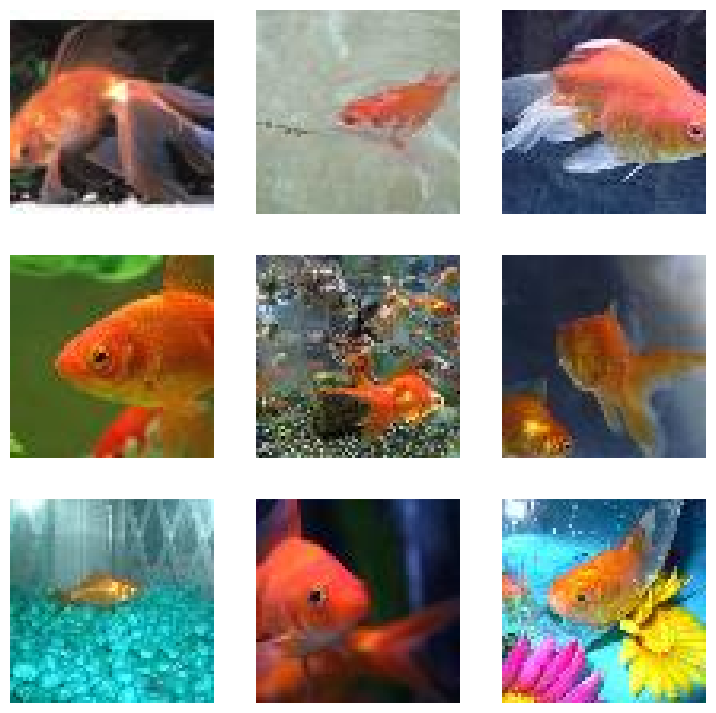

In [48]:
show_images(a[0:9])

In [50]:
e = encodify(a[0:9])
e.shape, 

(torch.Size([9, 4, 8, 8]),)

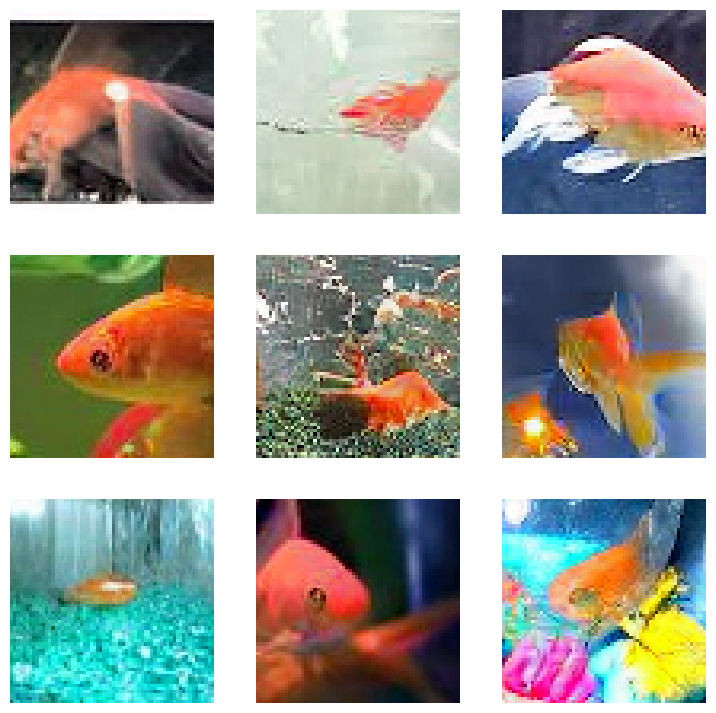

In [52]:
d = to_cpu(decodify(e)["sample"]).clamp(0,1)
show_images(d)

In [53]:
d.shape

torch.Size([9, 3, 64, 64])

- Save training latents

In [54]:
mmshape_t_lat = (100_000, 4, 8, 8)
path_t_lat = path_t/"tensor_lats.npmm"

In [55]:
if not path_t_lat.exists():
    memmap_tensor(tdl, path_t_lat, mmshape_t_lat, func=encodify)

Saved 256/100000 in 12.028613805770874
Saved 512/100000 in 11.39255166053772
Saved 768/100000 in 9.552424907684326
Saved 1024/100000 in 10.034568548202515
Saved 1280/100000 in 10.190378665924072
Saved 1536/100000 in 9.862911462783813
Saved 1792/100000 in 8.993943452835083
Saved 2048/100000 in 9.363160371780396
Saved 2304/100000 in 9.176679849624634
Saved 2560/100000 in 9.284176349639893
Saved 2816/100000 in 9.188297033309937
Saved 3072/100000 in 9.212081909179688
Saved 3328/100000 in 9.176247596740723
Saved 3584/100000 in 9.225622653961182
Saved 3840/100000 in 9.255157709121704
Saved 4096/100000 in 9.239387512207031
Saved 4352/100000 in 9.05960488319397
Saved 4608/100000 in 7.534305095672607
Saved 4864/100000 in 7.258327484130859
Saved 5120/100000 in 7.18555212020874
Saved 5376/100000 in 7.19708514213562
Saved 5632/100000 in 7.168052673339844
Saved 5888/100000 in 7.192629098892212
Saved 6144/100000 in 7.407546281814575
Saved 6400/100000 in 7.228353977203369
Saved 6656/100000 in 7.32523

In [56]:
mmshape_v_lat = (10_000, 4, 8, 8)
path_v_lat = path_v/"tensor_lats.npmm"

In [57]:
if not path_v_lat.exists():
    memmap_tensor(vdl, path_v_lat, mmshape_v_lat, func=encodify)

Saved 250/10000 in 8.567327737808228
Saved 500/10000 in 8.393224477767944
Saved 750/10000 in 7.107834100723267
Saved 1000/10000 in 6.815134525299072
Saved 1250/10000 in 6.626556158065796
Saved 1500/10000 in 6.7554004192352295
Saved 1750/10000 in 6.666078567504883
Saved 2000/10000 in 7.052356481552124
Saved 2250/10000 in 6.80033278465271
Saved 2500/10000 in 6.797386884689331
Saved 2750/10000 in 6.792499303817749
Saved 3000/10000 in 8.260385990142822
Saved 3250/10000 in 8.558142185211182
Saved 3500/10000 in 8.411167621612549
Saved 3750/10000 in 8.39712142944336
Saved 4000/10000 in 8.388154983520508
Saved 4250/10000 in 8.245406866073608
Saved 4500/10000 in 8.227562427520752
Saved 4750/10000 in 8.343129396438599
Saved 5000/10000 in 8.46527886390686
Saved 5250/10000 in 8.360325336456299
Saved 5500/10000 in 8.363075256347656
Saved 5750/10000 in 8.491440057754517
Saved 6000/10000 in 8.41533899307251
Saved 6250/10000 in 8.52733302116394
Saved 6500/10000 in 8.47571873664856
Saved 6750/10000 in 

- Verify that latents are present

In [58]:
np_lats_t = np.memmap(path_t_lat, dtype=np.float32, mode='r', shape=mmshape_t_lat)
np_lats_v = np.memmap(path_v_lat, dtype=np.float32, mode='r', shape=mmshape_v_lat)

t_lats = MemmapTensor(np_lats_t)
v_lats = MemmapTensor(np_lats_v)

In [59]:
t_lats[:16].shape, v_lats[:16].shape

(torch.Size([16, 4, 8, 8]), torch.Size([16, 4, 8, 8]))

In [60]:
t_lats[:16].mean(), t_lats[-16:].mean()

(tensor(1.2125), tensor(1.0178))

In [61]:
v_lats[:16].mean(), v_lats[-16:].mean()

(tensor(1.0173), tensor(1.4321))